<a href="https://colab.research.google.com/github/morganLantrade/Projets_machine_learning/blob/main/projet_mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://github.com/morganLantrade/Projets_machine_learning/blob/main/projet_mlp.ipynb" target="_blank"><img src="https://github.githubassets.com/images/modules/logos_page/GitHub-Mark.png" alt="Open In Colab" width="70" height="70" style="float:left; padding: 10px; " ></a>
# MLP : Multi-Layer Perceptron 

## Fonctionnement d'un MLP sur un échantillon

<a href="https://www.researchgate.net/figure/Multilayer-perceptron-MLP-architecture-with-two-hidden-layers-and-one-prediction-output_fig1_349630467"><img src="https://www.researchgate.net/publication/349630467/figure/fig1/AS:995457505447936@1614346972386/Multilayer-perceptron-MLP-architecture-with-two-hidden-layers-and-one-prediction-output.png" alt="Multilayer perceptron (MLP) architecture with two hidden layers and one prediction output." target="_blank"/></a>

## Fonctionnement d'un neurone d'une couche d'un perceptron

<a href="https://www.researchgate.net/figure/La-structure-dun-neurone-artificiel_fig3_303447451"><img src="https://www.researchgate.net/profile/Safae-Laqrichi/publication/303447451/figure/fig3/AS:644326015123459@1530630701780/La-structure-dun-neurone-artificiel.png" alt="3-La structure d'un neurone artificiel" target="_blank"/></a>

#### Importations

In [1]:
import sklearn
import warnings
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs, make_circles

warnings.filterwarnings('ignore')

### Fonctions d'activation

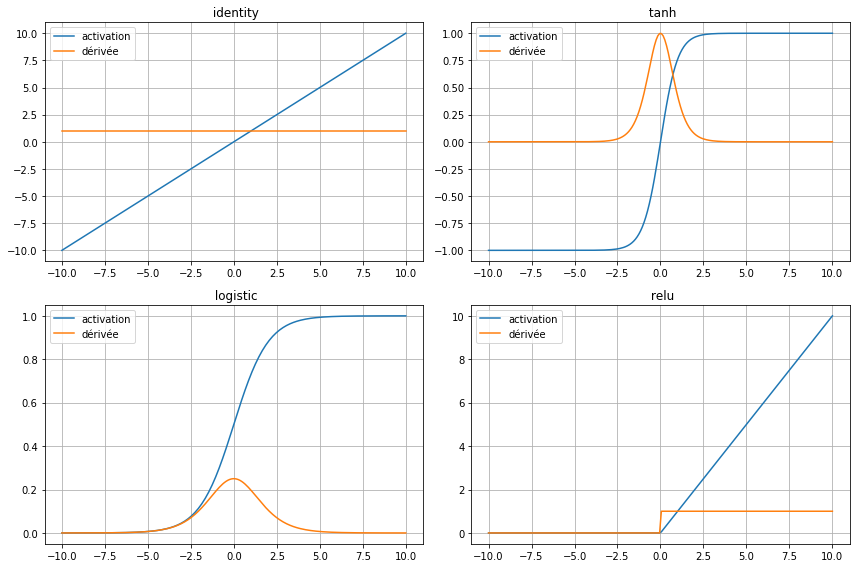

In [2]:
def identity(Z):
    return Z

def d_identity(A):
    return np.ones((A.shape))

def sigmoide(Z):
    return 1/(1+np.exp(-Z))

def d_sigmoide(A):
    return A*(1-A)

def tanh(Z): 
    return (np.exp(Z) - np.exp(-Z))/(np.exp(Z) + np.exp(-Z))

def d_tanh(A):
    return 1-A*A

def relu(Z):
    return np.where(Z>0,Z,0)

def d_relu(A):
    return np.where(A>0,1,0)


ACTIVATIONS={'identity' : (identity,d_identity) ,'logistic' : (sigmoide,d_sigmoide),
             'tanh': (tanh,d_tanh),'relu': (relu,d_relu)}

def afficherActivations(activations):
    i=0
    x=np.linspace(-10,10,200)
    fig, axs = plt.subplots(2,2)
    fig.set_figheight(8)
    fig.set_figwidth(12)
    for nom,a in activations.items():
        axs[i%2,i//2].plot(x,a[0](x),label='activation')
        axs[i%2,i//2].plot(x,a[1](a[0](x)),label='dérivée')
        axs[i%2,i//2].set_title(f' {nom}')
        axs[i%2,i//2].legend()
        axs[i%2,i//2].grid(True)
        i+=1
    fig.tight_layout()
afficherActivations(ACTIVATIONS)


        

<div class="alert alert-block alert-info">
<b>Remarque:</b> La liste d'activations est non éxhaustive et le choix de l'activation dépend du type de problème ( régression , classification ( binaire / multiclasse ) , ...
On commençera par implémenter avec la fonction sigmoïde et on essayera pour une classification binaire des couches cachées différentes et garder la derniere couche sigmoïde (pour finir entre 0 et 1).</div>

### Fonctions coût 

$$\begin{alignat}{2} L_{MSE}=& \frac{1}{m}.\sum_{k=1}^{m} (y_k-a_k)^2\\
L_{log\_loss}=& -\frac{1}{m}.\sum_{k=1}^{m} y_{k}.ln(a_{k})+(1-y_k).ln(1-a_k)\\
\end{alignat}$$

### Dérivées coût

$$\begin{alignat}{2} 
\frac{\partial L_{MSE}}{\partial a_k}=& \frac{2}{m}.\sum_{k=1}^{m} (a_k-y_k)\\
\frac{\partial L_{log\_loss}}{\partial a_k} =& \frac{1}{m}.\sum_{k=1}^m \frac{a_k-y_k}{a_k(1-a_k)})\\
\end{alignat}$$

In [3]:
def MSE_cost(A,y):
    return 1/y.shape[1]*np.sum((y-A)**2)

def log_loss(A,y,eps=10**(-15)):  #eps car log n'est pas définie en 0
    return - 1/y.shape[1]* np.sum(y *np.log(A+eps) + (1 - y) * np.log(1-A+eps))

def d_MSE_cost(A,y): #la somme 1 à m sera faite en produit matriciel (m,n)
    return 2/y.shape[1]*(A-y)

def d_log_loss(A,y,eps=10**(-15)): #la somme de 1 à m sera faite en produit matriciel avec (m,n)
    return 1/y.shape[1]*(A+eps-y)/((A+eps)*(1-A+eps))

COSTS={ 'log_loss':(log_loss,d_log_loss),'MSE': (MSE_cost,d_MSE_cost)}

### Formes de nos données vectorisées pour une couche l:
- m échantillons 
- $n^{[l-1]}$ variables  en entrée 
- $n^{[l]}$ en sortie 

$$\begin{alignat}{2} A^{[0]}= X = & \underbrace{\begin{bmatrix}
x_{1,1} & x_{1,2}&...& x_{1,m}\\
... &  ...&   ...&   ...&\\
x_{n^{[0]},1} & x_{n^{[0]},2}&...& x_{n^{[0]},m}\\
\end{bmatrix}}_{(n^{[0]},m)}\\
Y = & \underbrace{\begin{bmatrix}
y_{1} & y_{2} &... &y_{m}\end{bmatrix}}_{(1,m)}\\
W^{[l]} = & \underbrace{\begin{bmatrix}w^{[l]}_{1,1} & w^{[l]}_{1,2} &... &w^{[l]}_{1,n^{[l-1]}}\\
... & ... &... &... \\
w^{[l]}_{n^{[l]},1} & w^{[l]}_{n^{[l]},2} &... &w^{[l]}_{n^{[l]},n^{[l-1]}}\\
\end{bmatrix}}_{(n^{[l]},n^{[l-1]})} & B^{[l]}= \underbrace{\begin{bmatrix}
b^{[l]}_{1}\\
...\\
b^{[l]}_{n^{[l]}}\end{bmatrix}}_{(n^{[l]},1)}
\end{alignat}$$

<div class="alert alert-block alert-info">
<b>Remarque :</b>  Pour une simplication de notre vectorisation nous inclurons une ligne de 1 dans X et une colonne de b dans W.</div>

### Forward propagation 

$$
\forall l \in \{1,...,L\} : couches\\
\forall j \in \{1,...,n^{[L]}\} : neurones\\
\forall k \in \{1,...,m\} : échantillons
$$ 

$$\begin{alignat}{2} z^{[l]}_{jk} = & \sum_{i=1}^{n^{[l-1]}} w^{[l]}_{ji}.a^{[l-1]}_{ik} + b_j^{[l]}\\
\newline
\underbrace{Z}_{(n^{[l]},m)}^{[l]}  = & \begin{bmatrix}
\sum_{i=1}^{n^{[l-1]}} \color{red}w^{[l]}_{1,i}.\color{green}a^{[l-1]}_{i,1} + \color{blue}b_1^{[l]} &, &\sum_{i=1}^{n^{[l-1]}} \color{red}w^{[l]}_{1,i}.\color{green}a^{[l-1]}_{i,2} + \color{blue}b_1^{[l]} &, &... &, &\sum_{i=1}^{n^{[l-1]}} \color{red}w^{[l]}_{1,i}.\color{green}a^{[l-1]}_{im} + \color{blue}b_1^{[l]}\\
... &,  &... &, &... &,  & ...\\
\sum_{i=1}^{n^{[l-1]}} \color{red}w^{[l]}_{n^{[l]},i}.\color{green}a^{[l-1]}_{i,1} + \color{blue}b^{[l]}_{n^{[l]}} &, &\sum_{i=1}^{n^{[l-1]}}\color{red}w^{[l]}_{n^{[l]},i}.\color{green}a^{[l-1]}_{i,2} + \color{blue}b^{[l]}_{n^{[l]}} &, &... &, &\sum_{i=1}^{n^{[l-1]}} \color{red}w^{[l]}_{n^{[l]},i}.\color{green}a^{[l-1]}_{i,m} + \color{blue}b^{[l]}_{n^{[l]}}\\
\end{bmatrix}\\
\newline
\underbrace{Z}_{(n^{[l]},m)}^{[l]} = &\color{red}{\underbrace{{\begin{bmatrix}w^{[l]}_{1,1} & w^{[l]}_{1,2} &{...} &w^{[l]}_{1,n^{[l-1]}}\\
... & ... &... &... \\
w^{[l]}_{n^{[l]},1} & w^{[l]}_{n^{[l]},2} &{...} &w^{[l]}_{n^{[l]},n^{[l-1]}} \\
\end{bmatrix}}}_{(n^{[l]},n^{[l-1]})}}.\color{green}{\underbrace{\begin{bmatrix}
a^{[l-1]}_{1,1} & a^{[l-1]}_{1,2}&...& a^{[l-1]}_{1,m}\\
... &  ...&   ...&   ...&\\
a_{n^{[l-1]},1} & a^{[l-1]}_{n^{[l-1]},2}&...& a^{[l-1]}_{n^{[l-1]},m}\\
\end{bmatrix}}_{(n^{[l-1]},m)}}+\color{blue}{\underbrace{\begin{bmatrix}
b^{[l]}_1& ...& b^{[l]}_1\\
{...}& ...& ...\\
b^{[l]}_{n^{[l]}}& ...& b^{[l]}_{n^{[l]}} \end{bmatrix}}_{(n^{[l-1]},m)}}\\
\underbrace{Z}_{(n^{[l]},m)}^{[l]} = & W^{[l]}.A^{[l-1]} + B^{[l]} \\
\newline
\underbrace{A}^{[l]}_{(n^{[l]},m)}= &\frac{1}{1+e^{-Z^{[l]}}}
\end{alignat}$$

<div class="alert alert-block alert-success">
On obtient les activations où les lignes correspondent aux neurones et colonnes aux échantillons.</div>


<div class="alert alert-block alert-info">
<b>Remarque 1:</b> Le produit matriciel nous permet de faire la somme de 1 a m pour obtenir la matrice Z.
    
<b>Remarque 2:</b> On peut réduire B à une seule colonne car numpy permet d'additionner toute une ligne selon un une valeur.</div>

### Backward propagation à L couches
- activation : <span style="color:green"> **sigmoide** </span> 
- cost : <span style="color:brown"> **MSE** </span>
- cost : <span style="color:purple"> **log_loss** </span>

#### Calcul des dérivées de la derniere couche L : 


$$
\begin{alignat}{5}
\require{cancel}
&\underbrace{\frac{\partial L}{\partial W^{[L]}}}_{(n^{[L]},n^{[L-1]})} &= &\color{red}{\frac{\partial L}{\partial A^{[L]}} }*\color{green}{\frac{\partial A^{[L]}}{\partial Z^{[L]}}}*\color{blue}{\frac{\partial Z^{[L]}}{\partial W^{[L]}}}\\
&\underbrace{\color{blue}{\frac{\partial Z^{[L]}}{\partial W^{[L]}}}}_{(n^{[L-1]},m)} &= & A^{[L-1]}\\
&\underbrace{\color{blue}{\frac{\partial Z^{[L]}}{\partial B^{[L]}}}}_{(n^{[L-1]},1)} &= & 1\\
&\color{red}{\frac{\partial L_{MSE}}{\partial a_{ji}^{[L]}}}&= & \frac{2}{m}*\sum_{i=1}^{m} (a_{ji}-y_i)\\
&\color{red}{\frac{\partial L_{log\_loss}}{\partial a_{ji}^{[L]}}}&= & \frac{1}{m}*\sum_{i=1}^m \frac{(a_{ji}-y_i)}{a_{ji}(1-a_{ji})}\\
&\color{green}{\underbrace{\frac{\partial a^{[L]}_{ji}}{\partial z^{[L]}}}_{(n^{[L]},m)}}&= & a^{[L]}_{ji}*(1-a^{[L]}_{ji})\\
&\color{purple}{\frac{\partial L_{MSE}}{\partial {z_{ji}}^{[L]}}}& =&\color{red}{\frac{\partial L}{{\partial a^{[L]}_{ji}}} }*\color{green}{\frac{{\partial a^{[L]}_{ji}}}{\partial {z_{ji}}^{[L]}}}= \color{red}{\frac{2}{m}*\sum_{i=1}^m (a^{[L]}_{ji}-y_i)*\color{green}{a^{[L]}_{ji}*(1-a^{[L]}_{ji})}}\\
&\color{brown}{\frac{\partial L_{log\_loss}}{\partial {z_{ji}}^{[L]}}}& =&\color{red}{\frac{\partial L}{\cancel{\partial a^{[L]}_{ji}}} }*\color{green}{\frac{\cancel{\partial a^{[L]}_{ji}}}{\partial {z_{ji}}^{[L]}}}= \color{brown}{\frac{1}{m}*\sum_{i=1}^m (a^{[L]}_{ji}-y_i)}\\
\newline
\newline
&\color{purple}{\underbrace{\frac{\partial L_{MSE}}{\partial W^{[L]}}}_{(n^{[L]},n^{[L-1]})}} &= &\boxed{\color{red}{\underbrace{2*(A^{[L]}-y)*\color{green}A^{\color{green}[\color{green}L\color{green}]}\color{green}*\color{green}(\color{green}1\color{green}-\color{green}A^{\color{green}[\color{green}L\color{green}]}\color{green})}_{(n^{[L]},m)}} .\color{blue}{\underbrace{{}^TA^{[L-1]}}_{(m,n^{[L-1]})}}}\\
&\color{purple}{\underbrace{\frac{\partial L_{MSE}}{\partial B^{[L]}}}_{(n^{[L]},1)}} &= &\boxed{\color{red}{\frac{2}{m}*\sum_{i=1}^m (a^{[L]}_{ji}-y_i)*\color{green}{a^{[L]}_{ji}*(1-a^{[L]}_{ji})}}}\\
\newline
&\color{brown}{\underbrace{\frac{\partial L_{log\_loss}}{\partial W^{[L]}}}_{(n^{[L]},n^{[L-1]})}} &= &\boxed{\color{brown}{\underbrace{(A^{[L]}-y)}_{(n^{[L]},m)}} .\color{blue}{\underbrace{{}^TA^{[L-1]}}_{(m,n^{[L-1]})}}}\\
&\color{brown}{\underbrace{\frac{\partial L_{log\_loss}}{\partial B^{[L]}}}_{(n^{[L]},1)}} &= &\boxed{\color{brown}{\frac{1}{m}*\sum_{i=1}^m (a^{[L]}_{ji}-y_i)}}\\
\end{alignat}$$

<div class="alert alert-block alert-info">
<b>Même principe que la propagation avant :</b>
    
Le produit matriciel permet de vectoriser la somme de 1 à m .

Pour les gradients de B, numpy nous permet de faire la somme de chaque ligne. (axis=1)</div>



#### Calcul des dérivées de la couche avec la règle de la chaine.

$$
\begin{alignat}{5}
\require{cancel}
&{\underbrace{\frac{\partial L}{\partial W^{[l]}}}_{(n^{[l]},n^{[l-1]})}} &= &{\frac{\partial L}{\cancel{\partial Z^{[L]}}}}*{\cancel{\frac{\partial Z^{[L]}}{\partial A^{[L-1]}}}}*{\cancel{\frac{\partial A^{[L-1]}}{\partial Z^{[L-1]}}}}*...*{\frac{\cancel{\partial A^{[l+2]}}}{\partial Z^{[l+1]}}}* \color{gray}{\frac{\partial Z^{[l+1]}}{\partial A^{[l]}}}* \color{green}{\frac{\partial A^{[l]}}{\partial Z^{[l]}}}*\color{blue}{\frac{\partial Z^{[l]}}{\partial W^{[l]}}}  \\
&{\frac{\partial L}{\partial Z^{[l]}}}& = &{\frac{\partial L}{\partial Z^{[l+1]}}}* \color{gray}{\frac{\partial Z^{[l+1]}}{\partial A^{[l]}}} *  \color{green}{\frac{\partial A^{[l]}}{\partial Z^{[l]}}} \\
& &=&\underbrace{\underbrace{\color{gray}{{}^TW^{[l+1]}}}_{(n^{[l]},n^{[l+1]})}.\underbrace{{\frac{\partial L}{\partial Z^{[l+1]}}}}_{(n^{[l+1]},m)}* \underbrace{\color{green}{A^{[l]}*(1- A^{[l]})}}_{(n^{[l]},m)}}_{(n^{[l]},m)}\\
\newline
&\color{purple}{\underbrace{\frac{\partial L_{MSE}}{\partial W^{[l]}}}_{(n^{[l]},n^{[l-1]})}} &= &\boxed{\underbrace{\color{gray}{{}^TW^{[l+1]}}}_{(n^{[l]},n^{[l+1]})}.\underbrace{\color{purple}{\frac{\partial L_{MSE}}{\partial Z^{[l+1]}}}}_{(n^{[l+1]},m)}* \underbrace{\color{green}{A^{[l]}*(1- A^{[l]})}}_{(n^{[l]},m)}.\color{blue}{\underbrace{{}^TA^{[l-1]}}_{(m,n^{[l-1]})}}}\\
&\color{purple}{\underbrace{\frac{\partial L_{MSE}}{\partial B^{[l]}}}_{(n^{[l]},1)}} &=  &\boxed{\color{purple}{\sum _{k=0}^{m} \frac{\partial L_{MSE}}{\partial Z^{[l]}}}} \\
&\color{brown}{\underbrace{\frac{\partial L_{log\_loss}}{\partial W^{[l]}}}_{(n^{[l]},n^{[l-1]})}} &= &\boxed{\underbrace{\color{gray}{{}^TW^{[l+1]}}}_{(n^{[l]},n^{[l+1]})}.\underbrace{\color{brown}{\frac{\partial L_{log\_loss}}{\partial Z^{[l+1]}}}}_{(n^{[l+1]},m)}* \underbrace{\color{green}{A^{[l]}*(1- A^{[l]})}}_{(n^{[l]},m)}.\color{blue}{\underbrace{{}^TA^{[l-1]}}_{(m,n^{[l-1]})}}}\\
&\color{brown}{\underbrace{\frac{\partial L_{log\_loss}}{\partial B^{[l]}}}_{(n^{[l]},1)}} &=  &\boxed{\color{brown}{\sum _{k=0}^{m} \frac{\partial L_{log\_loss}}{\partial Z^{[l]}}}} \\
\end{alignat}$$

<div class="alert alert-block alert-success">
Nous avons réussi à exprimer les gradients de la couche L-1 par ceux de la couche L, nous pouvons donc maintenant récursivement
remonter jusqu a la couche 0.
Nous avons maintenant toutes les formules pour implémenter notre MLP avec une activation : sigmoïde et un cout : log_loss ou MSE.</div>


<a href="https://github.com/morganLantrade/Projets_machine_learning/blob/main/projet_mlp.ipynb" target="_blank"><img src="https://github.githubassets.com/images/modules/logos_page/GitHub-Mark.png" alt="Open In Colab" width="70" height="70" style="float:left; padding: 10px; " ></a>
### Implémentation du modèle sur github

In [4]:
from MLP import *

## Testons sur une classification binaire à deux variables

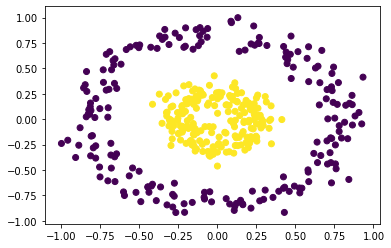

In [5]:
def cercle(n_circles,n_samples=400,noise=0.10,factor=0.3,random_state=0):
    '''retourne Xa,ya,Xt,yt formant 1 cercle , 2 cercles ou 4 cercles'''
    Xa, ya = make_circles(n_samples=n_samples, noise=0.10, factor=0.3, random_state=0)
    Xt, yt = make_circles(n_samples=n_samples//4, noise=0.10, factor=0.3, random_state=0)
    if n_circles==2:
        Xa=np.concatenate((Xa+[1,5],Xa+[-2,5]))
        Xt=np.concatenate((Xt+[1,5],Xt+[-2,5]))
        ya=np.concatenate((ya,ya))
        yt=np.concatenate((yt,yt))
    elif n_circles==4:
        Xa=np.concatenate((Xa+[1,5],Xa+[1,2],Xa+[-2,2],Xa+[-2,5]))
        Xt=np.concatenate((Xt+[1,5],Xt+[1,2],Xt+[-2,2],Xt+[-2,5]))
        ya=np.concatenate((ya,np.where(ya==1,0,1),ya,np.where(ya==1,0,1)))
        yt=np.concatenate((yt,np.where(yt==1,0,1),yt,np.where(yt==1,0,1)))
    ya = ya.reshape(ya.shape[0],1)
    yt = yt.reshape(yt.shape[0],1)
    return Xa/np.max(Xa),ya,Xt/np.max(Xt),yt

Xa,ya,Xt,yt=cercle(1)
plt.scatter(Xa[:,0], Xa[:,1], c=ya[:,0])
plt.show()

<div class="alert alert-block alert-info">
<b>Objectif : Comprendre l'influence </b>

- du nombre de neurones

- du nombre de couches 

- des fonctions d'activations et de coûts</div>

## Un cercle

###### MSE un neurone

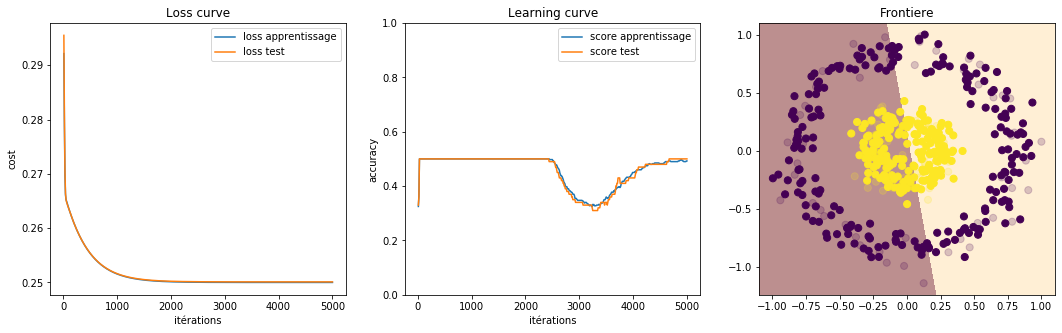

In [6]:
mlp=MLP(hidden_layers=[],activation='logistic',cost='MSE',learning_rate=0.2,max_iter=5000)
mlp.fit_show(Xa,ya,Xt,yt)

###### log_loss un neurone

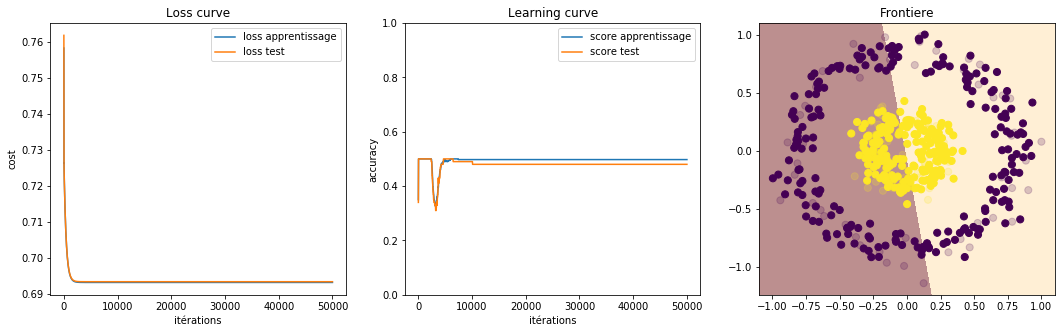

In [7]:
mlp=MLP(hidden_layers=[],activation='logistic',cost='log_loss',learning_rate=0.2,max_iter=50000)
mlp.fit_show(Xa,ya,Xt,yt)

<div class="alert alert-block alert-warning">
On essaye de séparer linéairement : impossible
</div>

#### Deux couches : Plusieurs neurones

##### 8 neurones , MSE, logistic

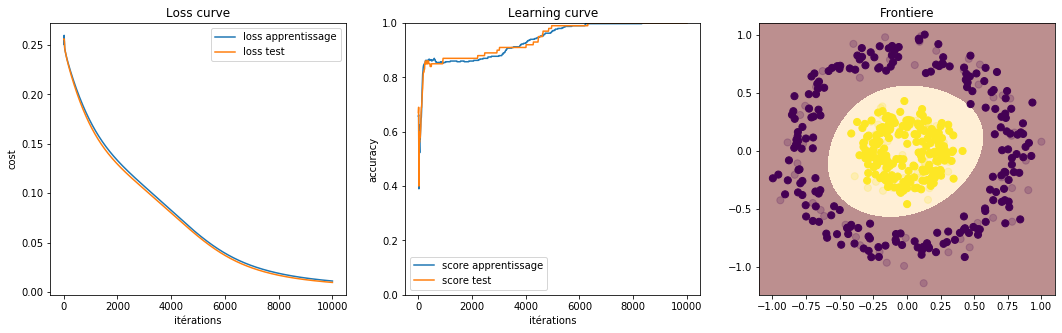

In [8]:
mlp=MLP(hidden_layers=[8],activation='logistic',cost='MSE',learning_rate=0.2,max_iter=10000)
mlp.fit_show(Xa,ya,Xt,yt)

#### 8 neurones , log_loss, logistic

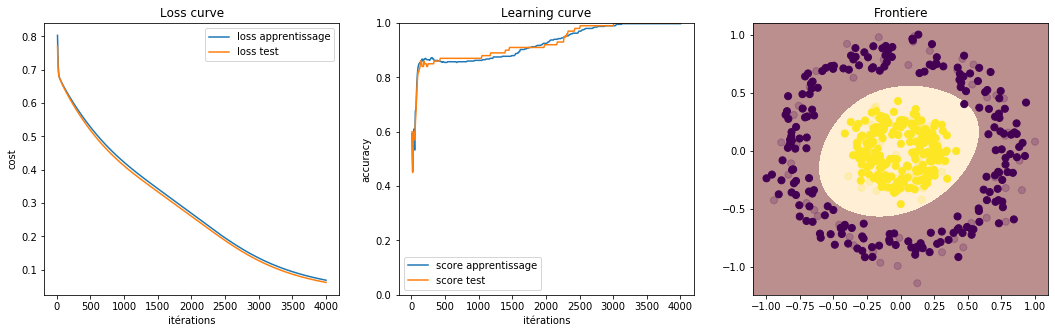

In [9]:
mlp=MLP(hidden_layers=[8],activation='logistic',cost='log_loss',learning_rate=0.2,max_iter=4000)
mlp.fit_show(Xa,ya,Xt,yt)

#### 8 neurones , MSE, Relu

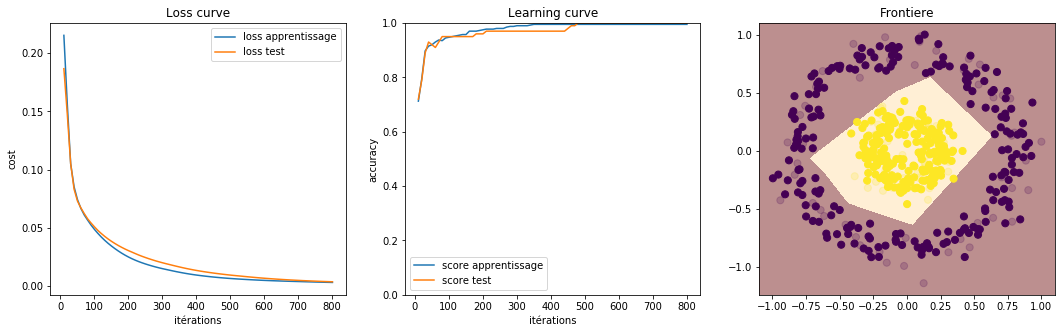

In [10]:
mlp=MLP(hidden_layers=[8],activation='relu',cost='MSE',learning_rate=0.2,max_iter=800)
mlp.fit_show(Xa,ya,Xt,yt)

<div class="alert alert-block alert-success">
On converge encore plus rapidement.
</div>

#### 8 neurones , log_loss, Relu

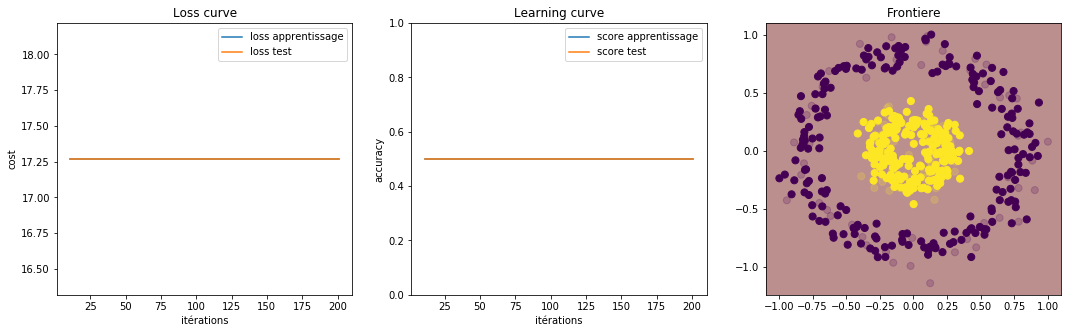

[array([[-3.39525578e+11,  3.03758379e+11],
       [-3.71233023e+10, -1.14862421e+11],
       [-5.65296249e+11,  7.56951328e+11],
       [-1.64138703e+12,  2.17079167e+12],
       [ 3.19039096e-01, -2.49370375e-01],
       [-4.00470240e+12,  5.29648438e+12],
       [-2.37370968e+12,  3.13938840e+12],
       [-1.58832824e+12,  2.10066939e+12]]), array([[-3.09442858e+14, -9.83426010e+12, -5.89226850e+14,
        -6.26744481e+14, -2.67888080e-01, -1.07334781e+15,
        -3.81136459e+14, -5.75466664e+14]])]


In [11]:
mlp=MLP(hidden_layers=[8],activation='relu',cost='log_loss',learning_rate=0.2,max_iter=200)
mlp.fit_show(Xa,ya,Xt,yt)
print(mlp.weights)

<div class="alert alert-block alert-warning">
Explosion des poids.
</div>

### Compliquons : 2 cercles

In [12]:
Xa,ya,Xt,yt=cercle(2)

#### 64 neurones , relu , MSE

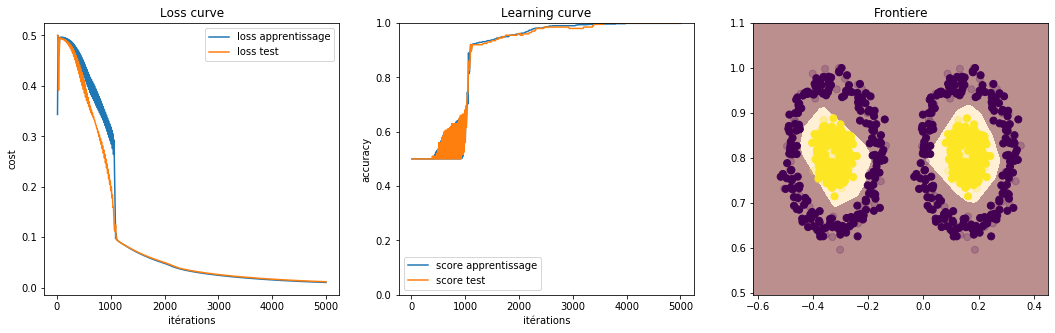

In [13]:
mlp=MLP(hidden_layers=[64],activation='relu',cost='MSE',learning_rate=0.2,max_iter=5000)
mlp.fit_show(Xa,ya,Xt,yt)

#### 32 x 64 neurones , relu , MSE

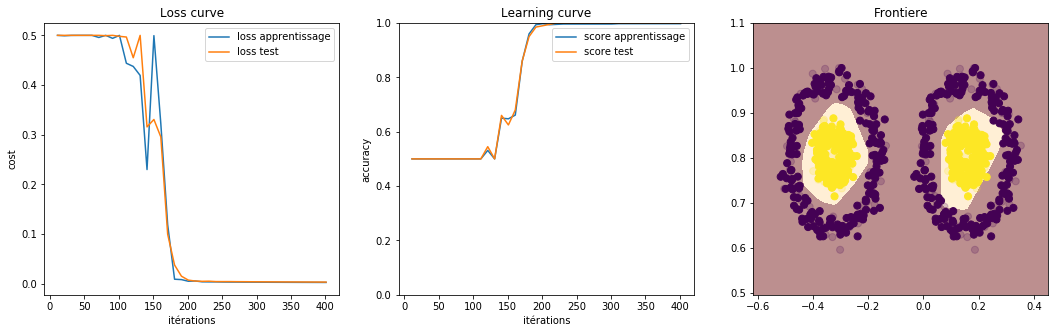

In [14]:
mlp=MLP(hidden_layers=[32,64],activation='relu',cost='MSE',learning_rate=0.2,max_iter=400)
mlp.fit_show(Xa,ya,Xt,yt)

#### 128x128 neurones , logistic , MSE

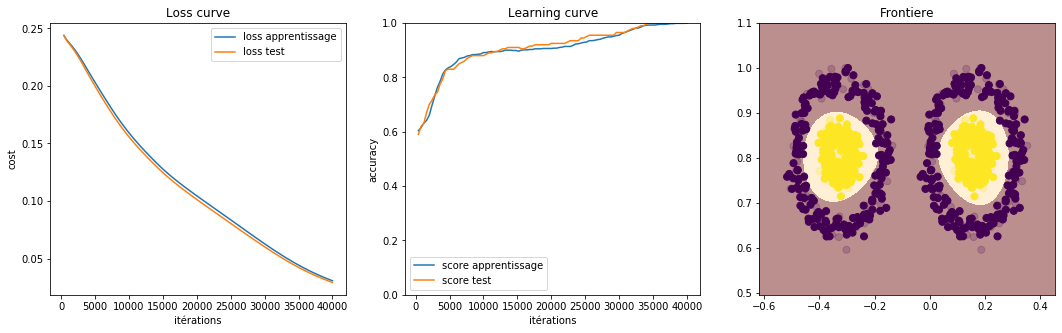

In [15]:
mlp=MLP(hidden_layers=[128,128],activation='logistic',cost='MSE',learning_rate=0.3,max_iter=40000)
mlp.fit_show(Xa,ya,Xt,yt,bins=400)

#### 128x128 neurones , logistic , log_loss

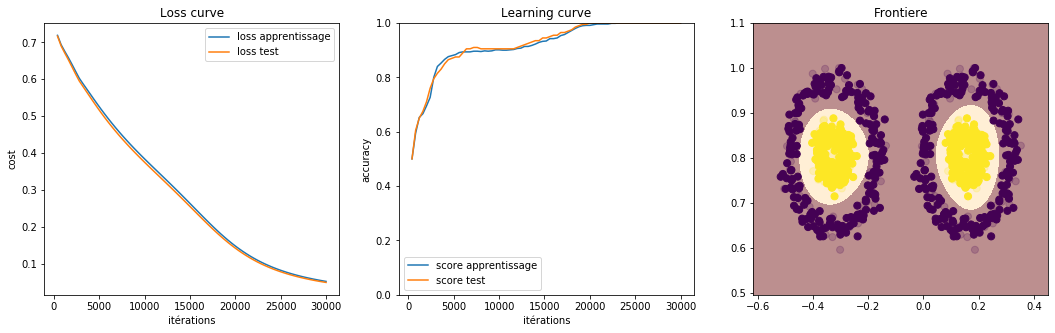

In [16]:
mlp=MLP(hidden_layers=[128,128],activation='logistic',cost='log_loss',learning_rate=0.25,max_iter=30000)
mlp.fit_show(Xa,ya,Xt,yt,bins=400)

<div class="alert alert-block alert-warning">
On remarque la fonction que la fonction relu est beaucoups plus efficaces, mais le modèle peut ne plus fonctionner selon l'initialisation des poids et des biais.
</div>

# Pour finir: 4 cercles couleurs inversées 

In [17]:
Xa,ya,Xt,yt=cercle(4)

##### 400 neurones , MSE , relu : meilleurs essai

In [ ]:
mlp=MLP(hidden_layers=[400],activation='relu',cost='MSE',learning_rate=0.02,max_iter=20000)
mlp.fit_show(Xa,ya,Xt,yt,bins=400)

<div class="alert alert-block alert-success">
[SUITE]...</div>